# Setup (Just run!)

In [ ]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install einops
    %pip install jaxtyping
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists(f"/content/{chapter}"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
        sys.path.append(f"/content/{repo}-main/{chapter}/exercises")
        os.remove("/content/main.zip")
        os.rename(f"{repo}-main/{chapter}", chapter)
        os.rmdir(f"{repo}-main")
        os.chdir(f"{chapter}/exercises")
else:
    raise Exception("If running from VSCode, you should copy code from the Streamlit page, not the Colab.")

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-4pcwwvo0
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-4pcwwvo0
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import sys, os
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import Literal, Callable
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part41_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from matplotlib.pyplot import imshow
from plotly_utils import imshow, line, scatter, bar

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

# EDA

In [ ]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")

gpt2_text = 'I open my umbrella because it is raining'

gpt2_tokens = gpt2_small.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)

print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0]
print(attention_pattern.shape)
gpt2_str_tokens = gpt2_small.to_str_tokens(gpt2_text)

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens,
    attention=attention_pattern,
    attention_head_names=[f"L0H{i}" for i in range(12)],
))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 9, 9])
Layer 0 Head Attention Patterns:


In [ ]:
# gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-medium")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-medium into HookedTransformer


# Proportion of Attention Paid to Delimiters

In [ ]:
def analyze_delimiter_attention(model, prompts, delimiter=" because"):
    """
    Computes and plots the proportion of attention directed to a given delimiter token.
    Args:
        model: The language model with .to_tokens, .to_str_tokens, and .run_with_cache methods.
        prompts: List of strings to be analyzed.
        delimiter: Delimiter to focus attention on, e.g., ' because' or ' so'.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads

    # Will accumulate the proportions layer-by-layer, head-by-head
    attn_prop_delim_all_prompts = torch.zeros(n_layers, n_heads)

    for prompt in prompts:
        tokens = model.to_tokens(prompt)
        logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)
        str_tokens = model.to_str_tokens(prompt)

        if delimiter not in str_tokens:
            print(f"Prompt '{prompt}' does not contain delimiter '{delimiter}'.")
            continue

        delim_idx = str_tokens.index(delimiter)
        for layer in range(n_layers):
            # attn shape: [n_heads, seq_len, seq_len]
            attn = cache["pattern", layer]
            # Sum of attention from all queries toward the delimiter token
            delim_sum = attn[:, :, delim_idx].sum(dim=1)
            # Total attention in each head
            total_sum = attn.sum(dim=(1, 2))
            proportion = delim_sum / total_sum
            attn_prop_delim_all_prompts[layer] += proportion

    # Average across prompts
    attn_prop_delim_all_prompts /= len(prompts)

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_prop_delim_all_prompts.numpy(), cmap="viridis")
    plt.title(f"Proportion of Attention to '{delimiter}'")
    plt.xlabel("Heads")
    plt.ylabel("Layers")
    plt.show()

    return attn_prop_delim_all_prompts


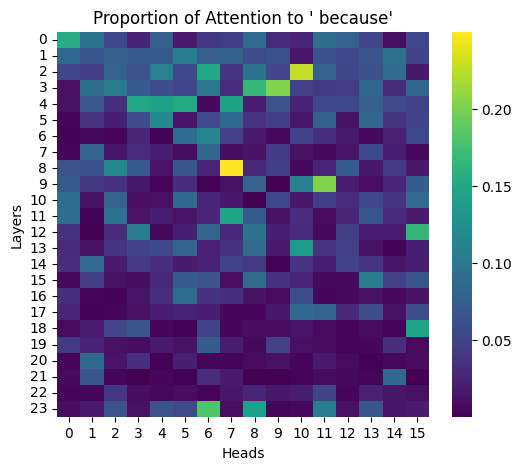

In [ ]:
prompts = [
    'Alice went to the park because she wanted to find a treasure.',
    'Alice plays guitar because she enjoys strumming melodies.',
    'Alice went to Paris because Paris is a good place for art.'
]

attention_map = analyze_delimiter_attention(gpt2_small, prompts, delimiter=" because")

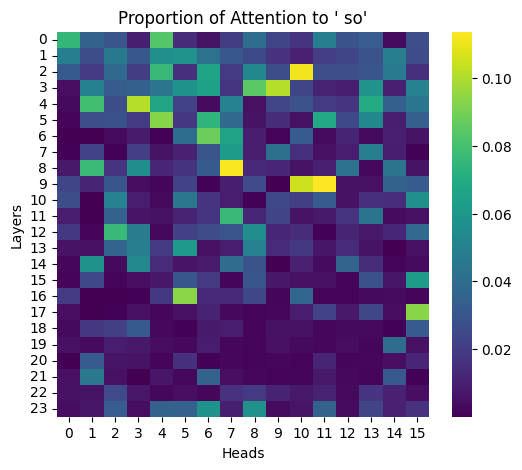

In [ ]:
prompts = [
    'Bob and Chris got work to do so they are eager to explore.',
    'Bob and Chris made a cake so they are excited and happy.'
    ]

attention_map = analyze_delimiter_attention(gpt2_small, prompts, delimiter=" so")

# Proporation of Effect-to-Cause or Cause-to-Effect Attention

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def measure_causal_attention(model, prompts, delimiter=" because",
                             cause_before=True, direction="cause->effect"):
    """
    Measures attention in a GPT-style model either from cause→effect or effect→cause.
    Args:
        model:      Your model with to_tokens, to_str_tokens, run_with_cache, etc.
        prompts:    List of strings to analyze.
        delimiter:  Token that separates cause from effect (e.g. " because", " so").
        cause_before:
            If True, cause tokens come before `delimiter`.
            If False, cause tokens come after `delimiter`.
        direction:  "cause->effect" or "effect->cause"
                    "cause->effect": cause tokens = queries, effect tokens = keys
                    "effect->cause": effect tokens = queries, cause tokens = keys
    Returns:
        A (layers x heads) tensor of average attention proportions.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    attn_prop_all_prompts = torch.zeros(n_layers, n_heads)

    for prompt in prompts:
        tokens = model.to_tokens(prompt)
        logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)
        str_tokens = model.to_str_tokens(prompt)

        if delimiter not in str_tokens:
            # Skip if prompt doesn't contain the delimiter
            continue

        delim_idx = str_tokens.index(delimiter)

        # Decide how to slice cause/effect
        if cause_before:
            cause_idxs = range(1, delim_idx)  # skip <|endoftext|> at index 0
            effect_idxs = range(delim_idx + 1, len(str_tokens))
        else:
            cause_idxs = range(delim_idx + 1, len(str_tokens))
            effect_idxs = range(1, delim_idx)

        for layer in range(n_layers):
            # attn shape: [n_heads, seq_len, seq_len]
            attn = cache["pattern", layer]

            if direction == "cause->effect":
                # cause are queries, effect are keys
                relevant_attn = attn[:, cause_idxs][:, :, effect_idxs]
            elif direction == "effect->cause":
                # effect are queries, cause are keys
                relevant_attn = attn[:, effect_idxs][:, :, cause_idxs]
            else:
                raise ValueError("direction must be either 'cause->effect' or 'effect->cause'")

            # Sum over the relevant rows/cols
            sum_relevant = relevant_attn.sum(dim=(1, 2))
            total_sum = attn.sum(dim=(1, 2))
            attn_prop_all_prompts[layer] += sum_relevant / total_sum

    attn_prop_all_prompts /= len(prompts)

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_prop_all_prompts.numpy(), cmap="viridis")
    if direction == 'cause->effect':
        plt.title("Proportion of Cause-to-Effect Attention")
    else:
        plt.title("Proportion of Effect-to-Cause Attention")
    plt.xlabel("Heads")
    plt.ylabel("Layers")
    plt.show()

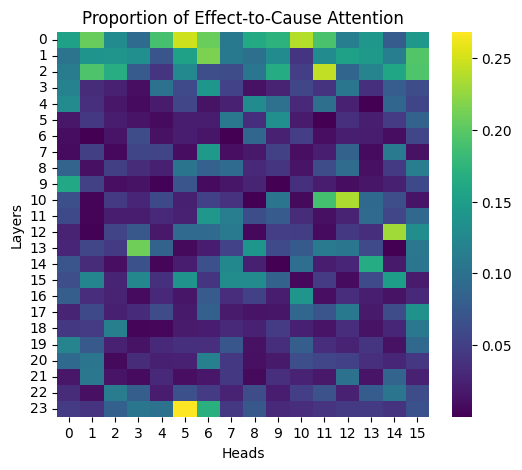

In [ ]:
prompts = [
    "Alice went to the park because she wanted to find a treasure.",
    "Alice plays guitar because she enjoys strumming melodies.",
    "Alice went to Paris because Paris is a good place for art."
]

measure_causal_attention(gpt2_small, prompts,
                                    delimiter=" because",
                                    cause_before=True,
                                    direction="effect->cause")

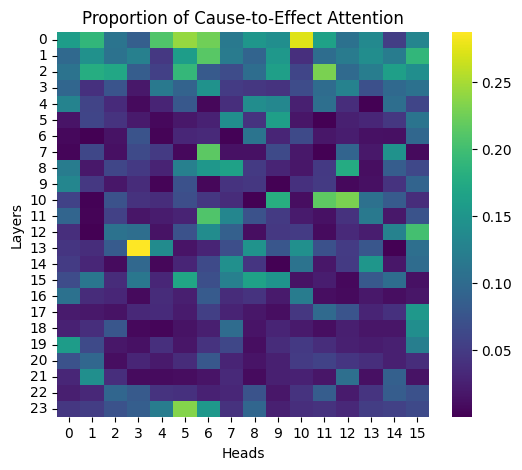

In [ ]:
prompts = [
    "Alice went to the craft fair so she could buy handmade gifts.",
    "Alice practiced daily so she would master the guitar."
]

measure_causal_attention(
    gpt2_small,
    prompts,
    delimiter=" so",
    cause_before=False,
    direction="cause->effect")

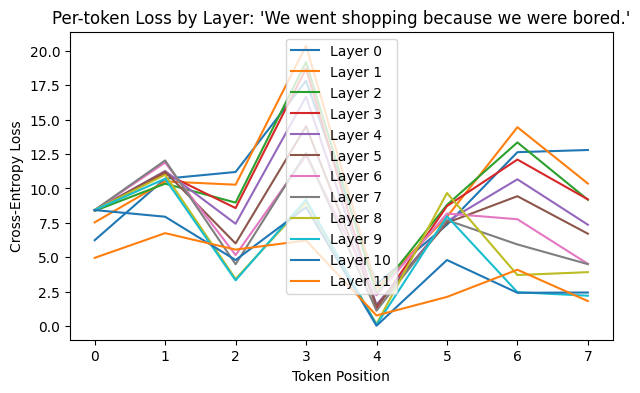

In [ ]:
import torch.nn.functional as F
def per_layer_loss(model, text):
    """
    For a given text string, returns a dict mapping layer index -> per-token loss tensor.
    """
    # Tokenize (with a BOS token if you want to measure from the very start)
    tokens = model.to_tokens(text, prepend_bos=True)  # shape [1, seq_len]

    # We'll store post-layer residual streams in this dict
    hidden_states = {}

    # Define a hook function that captures the post-layer residual
    def capture_resid_post(resid, hook):
        # Hook name is something like "blocks.<layer_idx>.hook_resid_post"
        # Extract layer index from it:
        # e.g. "blocks.11.hook_resid_post" -> layer_idx=11
        layer_idx = int(hook.name.split(".")[1])
        hidden_states[layer_idx] = resid.detach()  # shape [batch=1, seq_len, d_model]

    # Build hooks for every layer
    fwd_hooks = []
    for layer_idx in range(model.cfg.n_layers):
        hook_name = f"blocks.{layer_idx}.hook_resid_post"
        fwd_hooks.append((hook_name, capture_resid_post))

    # Run forward pass with hooks
    model.run_with_hooks(tokens, fwd_hooks=fwd_hooks)

    # Now compute partial logits at each layer by applying the final LN + unembed
    per_layer_losses = {}
    W_U = model.W_U  # [d_model, vocab_size]
    b_U = model.b_U  # [vocab_size]

    for layer_idx in range(model.cfg.n_layers):
        resid = hidden_states[layer_idx]                 # [1, seq_len, d_model]
        resid_ln = model.blocks[layer_idx].ln2(resid)
        # resid_ln = model.ln_final(resid)                # GPT-2 style final LN
                     # GPT-2 style final LN
        logits = resid_ln @ W_U + b_U                    # [1, seq_len, vocab_size]

        # Shift for causal language modeling:
        # Predict token i+1 from token i, so compare logits[:, :-1] to tokens[:, 1:]
        logits_for_ce = logits[:, :-1, :].squeeze(0)    # shape [seq_len-1, vocab_size]
        targets_for_ce = tokens[:, 1:].squeeze(0)       # shape [seq_len-1]

        # Per-token cross-entropy
        loss_per_token = F.cross_entropy(logits_for_ce, targets_for_ce, reduction='none')
        per_layer_losses[layer_idx] = loss_per_token.cpu()

    return per_layer_losses

# Example usage:
text = "We went shopping because we were bored."
losses_by_layer = per_layer_loss(gpt2_small, text)

# losses_by_layer[k] is a 1D tensor of per-token loss for layer k
# We can plot how loss changes across layers for each token position:
plt.figure(figsize=(7, 4))
for layer_idx, loss_tensor in losses_by_layer.items():
    plt.plot(loss_tensor.numpy(), label=f"Layer {layer_idx}")

plt.title(f"Per-token Loss by Layer: '{text}'")
plt.xlabel("Token Position")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()


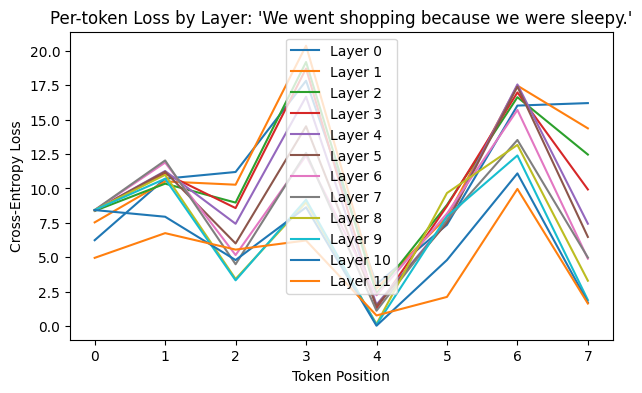

In [ ]:
# Example usage:
text = "We went shopping because we were sleepy."
losses_by_layer = per_layer_loss(gpt2_small, text)

# losses_by_layer[k] is a 1D tensor of per-token loss for layer k
# We can plot how loss changes across layers for each token position:
plt.figure(figsize=(7, 4))
for layer_idx, loss_tensor in losses_by_layer.items():
    plt.plot(loss_tensor.numpy(), label=f"Layer {layer_idx}")

plt.title(f"Per-token Loss by Layer: '{text}'")
plt.xlabel("Token Position")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

# Activation Patching

tensor([[20433,  2647]], device='cuda:0')
tensor([[20433,  2647]], device='cuda:0')
Clean string 0:     ['<|endoftext|>Jane will eat it because John is getting the', '<|endoftext|>Jane will eat it because John is getting the'] 
Corrupted string 0: ['<|endoftext|>Jane will sing it because John is getting the', '<|endoftext|>Jane will sing it because John is getting the']
Clean logit diff: 1.8640
Corrupted logit diff: -3.5017


  0%|          | 0/120 [00:00<?, ?it/s]

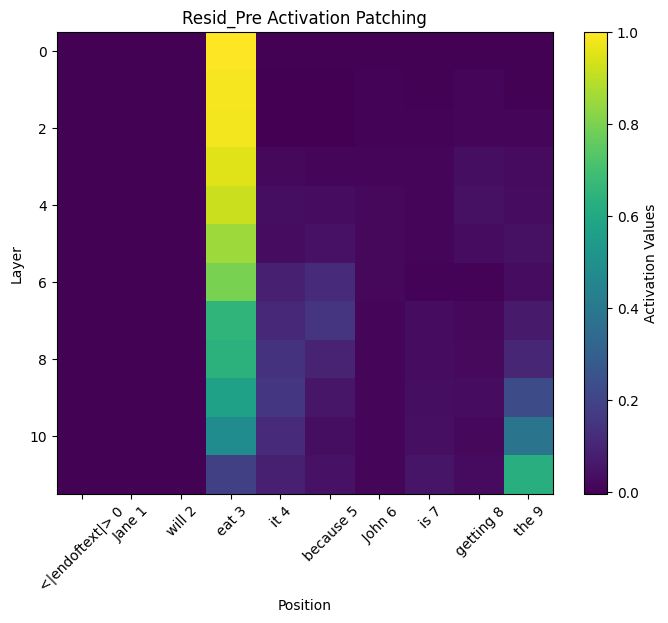

In [ ]:
# Using your defined clean_tokens and corrupted_tokens

clean_tokens = model.to_tokens(["Jane will eat it because John is getting the", "Jane will eat it because John is getting the"])
corrupted_tokens = model.to_tokens(["Jane will sing it because John is getting the", "Jane will sing it because John is getting the"])

clean_answers = [(" sandwich", " music")]
clean_answer_tokens = t.concat([
    model.to_tokens(answers, prepend_bos=False).T for answers in clean_answers
])
print(clean_answer_tokens)

corr_answers = [(" sandwich", " music")]
corr_answer_tokens = t.concat([
    model.to_tokens(answers, prepend_bos=False).T for answers in clean_answers
])
print(corr_answer_tokens)

print(
    "Clean string 0:    ", model.to_string(clean_tokens), "\n"
    "Corrupted string 0:", model.to_string(corrupted_tokens)
)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"],
    per_prompt: bool = False
) -> Float[Tensor, "*batch"]:
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # SOLUTION
    # Only the final logits are relevant for the answer
    final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    # Get the logits corresponding to the indirect object / subject tokens respectively
    answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
    # Find logit difference
    correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
    answer_logit_diff = correct_logits - incorrect_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, clean_answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, corr_answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

def ioi_metric(
    logits,
    answer_tokens=answer_tokens,
    corrupted_logit_diff=corrupted_logit_diff,
    clean_logit_diff=clean_logit_diff,
):
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

from transformer_lens import patching

act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=corrupted_tokens,
    clean_cache=clean_cache,
    patching_metric=ioi_metric
)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

plt.figure(figsize=(8, 6))  # Adjust figure size

# Display the heatmap
plt.imshow(
    act_patch_resid_pre.cpu(),
    cmap="viridis",  # Choose a colormap similar to Plotly's 'Viridis'
    aspect="auto"
)

# Add labels and title
plt.colorbar(label="Activation Values")
plt.xlabel("Position")
plt.ylabel("Layer")
plt.title("Resid_Pre Activation Patching")

# Set custom labels for x-axis if `labels` is provided
if 'labels' in locals() and labels is not None:
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)

plt.show()




In [ ]:
act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(
    model,
    corrupted_tokens,
    clean_cache,
    ioi_metric
)

  0%|          | 0/144 [00:00<?, ?it/s]

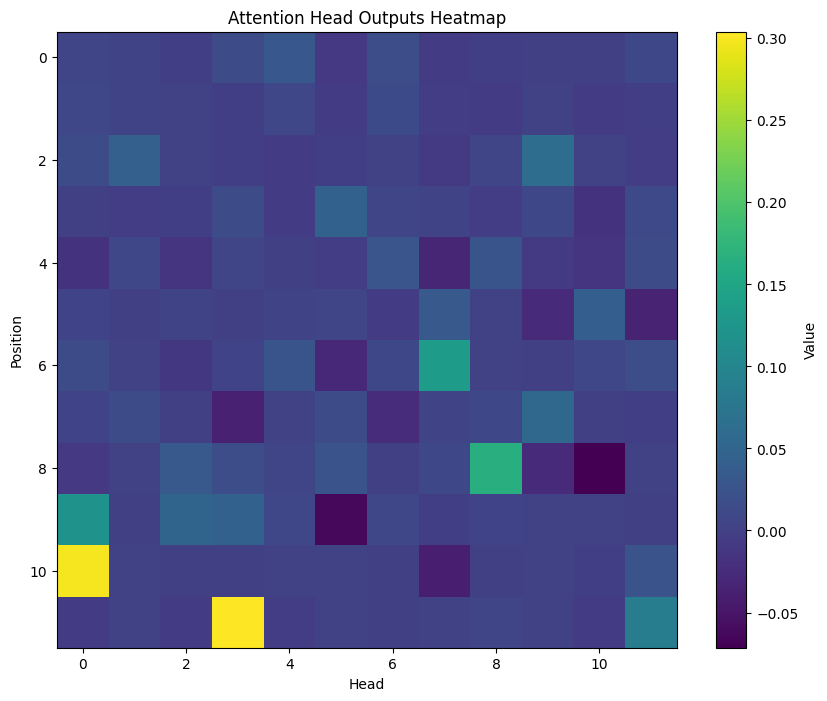

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(act_patch_attn_head_out_all_pos.cpu(), cmap="viridis", aspect="auto")
plt.colorbar(label="Value")
plt.xlabel("Head")
plt.ylabel("Position")
plt.title("Attention Head Outputs Heatmap")
plt.show()

# Activation patching from datasets

In [ ]:
import torch as t
import os
from transformer_lens import patching
import matplotlib.pyplot as plt
import numpy as np

model = HookedTransformer.from_pretrained("gpt2-small")

device = t.device("cuda" if t.cuda.is_available() else "cpu")  # Use GPU if available
data_dir = "../content"  # Directory where the datasets are stored

# Iterate through all dataset files
for dataset_file in os.listdir(data_dir):
    if dataset_file.endswith("_dataset.txt"):
        template_id = dataset_file.split("_")[0]
        print(f"Processing dataset for {template_id}...")

        dataset_path = os.path.join(data_dir, dataset_file)
        clean_sentences = []
        corrupted_sentences = []

        # Load the dataset and split into clean and corrupted sentences
        with open(dataset_path, "r") as f:
            for i, line in enumerate(f):
                clean, corrupted = line.strip().split(" | ")
                clean_sentences.append(clean.strip())
                corrupted_sentences.append(corrupted.strip())
                if i >= 1:
                    break

        # Tokenize clean and corrupted sentences excluding the last word
        clean_tokens_batch = model.to_tokens([s.rsplit(" ", 1)[0] for s in clean_sentences]).to(device)
        corrupted_tokens_batch = model.to_tokens([s.rsplit(" ", 1)[0] for s in corrupted_sentences]).to(device)

        # Extract the last words as answer tokens
        # answer_tokens = t.stack([
        #     t.tensor(
        #         [model.to_tokens([" " + clean_sentences[i].split()[-1]], prepend_bos=False)[0, 0].item(),
        #          model.to_tokens([" " + corrupted_sentences[i].split()[-1]], prepend_bos=False)[0, 0].item()],
        #         device=device
        #     )
        #     for i in range(len(clean_sentences))
        # ])
        answers = [
            (" " + clean_sentences[i].split()[-1], " " + corrupted_sentences[i].split()[-1])
            for i in range(len(clean_sentences))
        ]

        answer_tokens = t.concat([
            model.to_tokens(answers, prepend_bos=False).T for answers in answers
        ])

        print(clean_tokens_batch)
        print(corrupted_tokens_batch)
        print(answers)
        print(answer_tokens)

        # Run the model with cache for clean tokens
        # clean_logits, clean_caches = model.run_with_cache(clean_tokens)

        # Initialize activation patching results
        act_patch_resid_pre_sum = None
        num_samples = len(corrupted_sentences)

        for i in range(num_samples):
            # Tokenize the corrupted sentence (excluding the last word)
            corrupted_tokens = corrupted_tokens_batch[i].unsqueeze(0).to(device)

            # Run the model with cache for the corrupted tokens
            corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

            # Extract the clean cache for the current sentence
            # current_clean_cache = {key: clean_caches[key][i].unsqueeze(0) for key in clean_caches.keys()}
            clean_tokens = clean_tokens_batch[i].unsqueeze(0).to(device)
            clean_logits, clean_cache = model.run_with_cache(clean_tokens)

            # Identify the perturbed position
            perturbed_position = next(
                j for j, (clean_tok, corrupted_tok) in enumerate(zip(clean_tokens[0], corrupted_tokens[0]))
                if clean_tok != corrupted_tok
            )

            # Compute logit differences
            def logits_to_ave_logit_diff(
                logits: t.Tensor,
                answer_tokens: t.Tensor = answer_tokens[i].unsqueeze(0),
                per_prompt: bool = False
            ) -> t.Tensor:
                final_logits = logits[:, -1, :]  # Use the last logits
                answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
                correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
                print(correct_logits)
                print(incorrect_logits)
                logit_diff = correct_logits - incorrect_logits
                print(logit_diff)
                return logit_diff if per_prompt else logit_diff.mean()

            def logits_difference_metric(
                clean_logits: t.Tensor,
                corrupted_logits: t.Tensor
            ) -> t.Tensor:
                """
                Computes the difference between clean and corrupted logits.
                Focuses on the logit shift caused by perturbation.
                """
                # Extract logits for the last token
                clean_final_logits = clean_logits[:, -1, :]  # Last token for clean
                corrupted_final_logits = corrupted_logits[:, -1, :]  # Last token for corrupted

                # Compute the difference
                diff = t.mean((clean_final_logits - corrupted_final_logits) ** 2)

                return diff


            clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens[i].unsqueeze(0))
            corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens[i].unsqueeze(0))

            # def ioi_metric(logits, answer_tokens=answer_tokens[i].unsqueeze(0), corrupted_logit_diff=corrupted_logit_diff, clean_logit_diff=clean_logit_diff):
            #     patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
            #     return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

            def ioi_metric(clean_logits: t.Tensor, corrupted_logits: t.Tensor) -> t.Tensor:
                """
                Metric to measure the effect of perturbation on the logits.
                """
                return logits_difference_metric(clean_logits, corrupted_logits)

            # Perform activation patching for this corrupted input with the corresponding clean cache
            act_patch_resid_pre = patching.get_act_patch_resid_pre(
                model=model,
                corrupted_tokens=corrupted_tokens,
                clean_cache=clean_cache,
                patching_metric=ioi_metric
            )

            print(act_patch_resid_pre)


            # Accumulate activation patching results
            if act_patch_resid_pre_sum is None:
                act_patch_resid_pre_sum = act_patch_resid_pre
            else:
                act_patch_resid_pre_sum += act_patch_resid_pre

        # Compute average activation patching results
        avg_act_patch_resid_pre = act_patch_resid_pre_sum / num_samples
        print(avg_act_patch_resid_pre.shape)
        print(avg_act_patch_resid_pre)

        # Generate labels for visualization
        labels = [
            "perturbed" if j == perturbed_position else f"{tok} {j}"
            for j, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
        ]

        # Display the heatmap
        plt.figure(figsize=(8, 6))
        plt.imshow(
            avg_act_patch_resid_pre.cpu().numpy(),
            cmap="viridis",
            aspect="auto"
        )
        plt.colorbar(label="Activation Values")
        plt.xlabel("Position")
        plt.ylabel("Layer")
        plt.title(f"Resid_Pre Activation Patching (Average) - {template_id}")
        plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
        plt.show()

        print(f"Finished processing dataset for {template_id}.\n")



Loaded pretrained model gpt2-small into HookedTransformer
Processing dataset for ALB...
tensor([[50256,  7554,   550,   284,  2353,   780,   339,   318,  1016,   284,
           262],
        [50256,  7554,   550,   284,  2050,   780,   339,   318,  1016,   284,
           262]], device='cuda:0')
tensor([[50256,  7554,   550,   284,  9280,   780,   339,   318,  1016,   284,
           262],
        [50256,  7554,   550,   284,  9422,   780,   339,   318,  1016,   284,
           262]], device='cuda:0')
[(' beach', ' beach'), (' library', ' library')]
tensor([[10481, 10481],
        [ 5888,  5888]], device='cuda:0')
tensor([11.3000], device='cuda:0')
tensor([11.3000], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([11.5553], device='cuda:0')
tensor([11.5553], device='cuda:0')
tensor([0.], device='cuda:0')


  0%|          | 0/132 [00:00<?, ?it/s]

TypeError: ioi_metric() missing 1 required positional argument: 'corrupted_logits'